# Charging the data

## 1. Import libraries

In [1]:
import numpy as np

import pandas as pd

from skimage import filters

from scipy.interpolate import interp1d, RegularGridInterpolator,make_interp_spline
from scipy.integrate import simpson



from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset

import os

from tqdm import tqdm 

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable


from pathlib import Path

In [2]:
plt.rcParams.update({
  'axes.titlesize': 'x-large',  # heading 1
  'axes.labelsize': 'large',   # heading 2
  'xtick.labelsize': 'medium',         # fontsize of the ticks
  'ytick.labelsize': 'medium',         # fontsize of the ticks
  'font.family': 'serif',        # Font family
  'text.usetex': False,          # Do not use LaTeX for text rendering
  'figure.figsize': (10, 8),     # Default figure size
  'savefig.dpi': 300,            # High resolution for saving figures
  'savefig.format': 'png',       # Default format for saving figures
  'legend.fontsize': 'small',  # Font size for legends
  'lines.linewidth': 2,          # Line width for plots
  'lines.markersize': 8,         # Marker size for plots,
  'axes.formatter.useoffset': False,  # Disable offset
  'axes.formatter.use_mathtext': True,  # Use scientific notation
  'axes.formatter.limits': (-3, 4),  # Use scientific notation for values over 10^2
  'axes.labelsize': 'large',     # Font size for axes labels
  'figure.titlesize': 'xx-large', # Font size for suptitles (heading 1)
  'axes.formatter.use_locale': False  # Do not use locale settings
})


## 2. Charge the data

### 2.1 Charge the raw data

First let's define the path to the data and use a testing file. Also, some quantities useful for the dimensiones to be treated later in the code.

In [4]:
images_output = Path("../thesis_images")
if not os.path.exists(images_output):
    os.makedirs(images_output)

In [5]:
ptm = Path("../data")
filename = "080000"

nlam = 300 #this parameter is useful when managing the Stokes parameters #wavelenght interval - its from 6300 amstroengs in steps of 10 amstroengs
nx = 480
ny = 480 
nz = 256 #height axis

Charge the data corresponding to temperature, density, magnetic field and velocity

In [5]:
print(f"""
        ######################## 
        Reading {filename} MuRAM data...
        ######################## 
              """)

geom_path = ptm / "geom_height"
print("Charging temperature ...")
mtpr = np.load(geom_path / f"mtpr_{filename}.npy").flatten()
print("mtpr shape:", mtpr.shape)

print("Charging magnetic field vector...")
mbxx = np.load(geom_path / f"mbxx_{filename}.npy")
mbyy = np.load(geom_path / f"mbyy_{filename}.npy")
mbzz = np.load(geom_path / f"mbzz_{filename}.npy")

coef = np.sqrt(4.0*np.pi) #cgs units conversion300

mbxx=mbxx*coef
mbyy=mbyy*coef
mbzz=mbzz*coef
print("mbxx shape:", mbxx.shape)
print("mbyy shape:", mbyy.shape)
print("mbzz shape:", mbzz.shape)

print("Charging density...")
mrho = np.load(geom_path / f"mrho_{filename}.npy")
print("mrho shape:", mrho.shape)

print("Charge velocity...")
mvzz = np.load(geom_path / f"mvzz_{filename}.npy")
print("mvzz shape:", mvzz.shape)

mvzz = mvzz/mrho

muram_box = np.stack([mtpr, mrho, mvzz, mbxx, mbyy, mbzz, ], axis=-1)
muram_box = np.array([mtpr, mrho, mvzz, mbxx, mbyy, mbzz])
muram_box = np.moveaxis(muram_box, 0, 1)
muram_box = np.reshape(muram_box, (nx, nz, ny, muram_box.shape[-1]))
muram_box = np.moveaxis(muram_box, 1, 2)

print(f"""
        ######################## 
        Finished!
        ######################## 
              """)

del mtpr, mrho, mbxx, mbyy, mbzz, mvzz


        ######################## 
        Reading 080000 MuRAM data...
        ######################## 
              
Charging temperature ...
mtpr shape: (58982400,)
Charging magnetic field vector...
mbxx shape: (58982400,)
mbyy shape: (58982400,)
mbzz shape: (58982400,)
Charging density...
mrho shape: (58982400,)
Charge velocity...
mvzz shape: (58982400,)

        ######################## 
        Finished!
        ######################## 
              


In [ ]:
muram_box.shape

(480, 480, 256, 6)

For the vertical representation, we'll take the mean value for each surface.

In [ ]:

domain_heights = np.array(range(0, 256)) * 10
mean_T = muram_box[...,0].mean(axis = (0,1)) 
T_indices = np.argsort(mean_T)
mean_T = mean_T[T_indices]
domain_heights = domain_heights[T_indices]

Teff = 5780
height_T_func = make_interp_spline(mean_T, domain_heights, k=3)
height_Teff = height_T_func(Teff)
print(f"Height at Teff = {height_Teff} km")

domain_heights = domain_heights - height_Teff
domain_heights = np.sort(domain_heights)/1000 #in Mm




Height at Teff = 1897.4793049627453 km


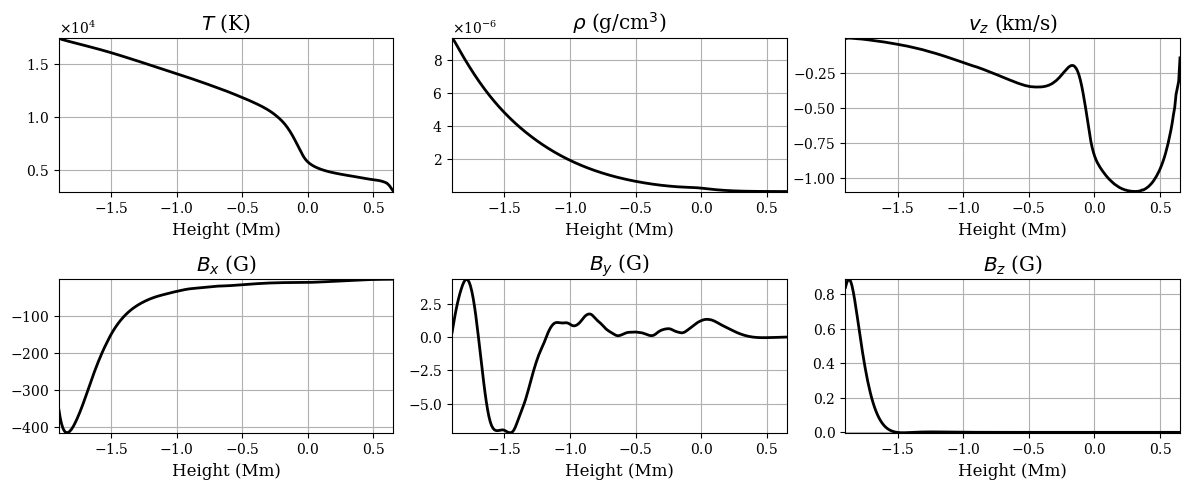

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(4*3, 2*2.5))

quantities = [
    (0, r"$T$", "K", "inferno"),
    (1, r"$\rho$", r"g/cm$^3$", "summer"),
    (2, r"$v_z$", "km/s", "bwr_r"),
    (3, r"$B_x$", "G", "Spectral"),
    (4, r"$B_y$", "G",  "Spectral"),
    (5, r"$B_z$", "G", "PiYG"),
]


for i, (param_idx, title, unit, cmap) in enumerate(quantities):
  data = muram_box[...,param_idx].mean(axis = (0,1)) 
  if title in [r"$v_z$"]:  # Convert from cm/s to km/s
    data /= 1e5
    
  iax = ax[i // 3, i % 3]
  
  iax.plot(domain_heights, data, "k")
  iax.set_xlabel("Height (Mm)")
  iax.set_title(f"{title} ({unit})")
  iax.set_xlim(domain_heights.min(), domain_heights.max())
  iax.grid(True)
  iax.set_ylim(data.min(), data.max())
plt.tight_layout(w_pad=1.0, h_pad=1.0)
fig.savefig(images_output / "muram_box_mean_profile.png", dpi=300)

plt.show()


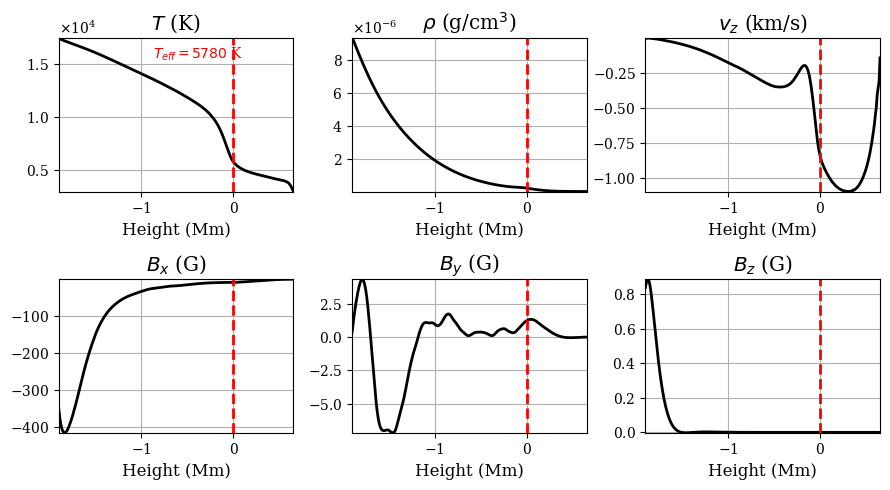

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(3*3, 2*2.5))

quantities = [
    (0, r"$T$", "K", "inferno"),
    (1, r"$\rho$", r"g/cm$^3$", "summer"),
    (2, r"$v_z$", "km/s", "bwr_r"),
    (3, r"$B_x$", "G", "Spectral"),
    (4, r"$B_y$", "G",  "Spectral"),
    (5, r"$B_z$", "G", "PiYG"),
]

for i, (param_idx, title, unit, cmap) in enumerate(quantities):
    data = muram_box[...,param_idx].mean(axis = (0,1)) 
    if title in [r"$v_z$"]:  # Convert from cm/s to km/s
        data /= 1e5
    
    iax = ax[i // 3, i % 3]
    
    iax.plot(domain_heights, data, "k")
    iax.axvline(x=0, color='red', linestyle='--')
    if title == r"$T$":
        iax.text(0.4, 0.95, r'$T_{eff} = 5780$ K', color='red', transform=iax.transAxes, verticalalignment='top')
    iax.set_xlabel("Height (Mm)")
    iax.set_title(f"{title} ({unit})")
    iax.set_xlim(domain_heights.min(), domain_heights.max())
    iax.grid(True)
    iax.set_ylim(data.min(), data.max())
plt.tight_layout(w_pad=1.0, h_pad=1.0)
fig.savefig(images_output / "muram_box_mean_profile_with_teff.png", dpi=300)

plt.show()

Let's plot them to check their distribution along height and over a surface

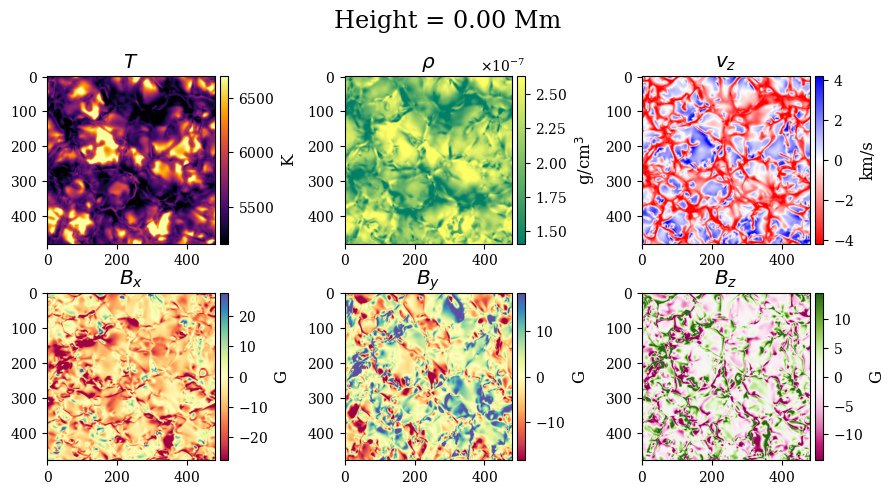

In [ ]:
height_pix = 190
fig, ax = plt.subplots(2, 3, figsize=(3*3, 2*2.5))
fig.suptitle(f"Height = {domain_heights[height_pix]:.2f} Mm")
for i, (param_idx, title, unit, cmap) in enumerate(quantities):
  data = muram_box[...,height_pix,param_idx]
  if title in [r"$v_z$"]:  # Convert from cm/s to km/s
    data /= 1e5
  if title in [r"$v_z$", r"$B_x$", r"$B_y$",r"$B_z$"]:  # Magnetic field components and velocity need symmetric colorbars
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = -orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else orig_q5
    vmax = orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else -orig_q5
  else:
    # Calculate quantiles for colorbar limits based on original data
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = orig_q5
    vmax = orig_q95
  im = ax[i // 3, i % 3].imshow(data, cmap = cmap, vmin = vmin, vmax = vmax)
  ax[i // 3, i % 3].set_title(title)
  divider = make_axes_locatable(ax[i // 3, i % 3])
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(im, cax=cax, label=unit)
plt.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "muram_box_fixed_height.png", dpi=300)

plt.show()

In [ ]:
first_positive_index = np.argmax(domain_heights > 0)
print(first_positive_index)

190


### 2.2 Optical Depth Stratification

Once we have the respective quantities charged, we would like to stratify the magnitudes with respect to logarithm of optical depth nodes $\log \tau$ for a comparison of the results with real data. Let's do it with just one pixel. The nodes we are gonna use correspond to the [MODEST dataset](https://www.aanda.org/articles/aa/abs/2024/07/aa49269-24/aa49269-24.html), which values are $\log \tau = 0, -0.8, -2.0$.

First, let's charge the pressure data corresponding to our simulation snapshot.

In [ ]:
 # Load the pressure
eos = np.fromfile(os.path.join(geom_path,  f"eos.{filename}"), dtype=np.float32)
eos = eos.reshape((2, nx, nz, ny), order = "C")
mpre = eos[1]
mpre = np.moveaxis(mpre, 1, 2)  # Pressure array to be used in the calculation of the optical depth
del eos
mpre.shape

(480, 480, 256)

For doing the stratification corresponding to optical depth, we will use the following calculation
\begin{equation}
    \tau(z;T,P) = \int_{z_{\text{max}}}^{z} \kappa(T,P) \rho dz
\end{equation}
which correspond to the calculation of the optical depth parting from the opacity values multiplied by the volumetric density of the gas. This calculation correspond to the assumption of parallel atmospheres that can be applied on the photosphere thanks to it's behaviour that can be described aproximately through local thermodynamic equilibrium (LTE).

To this purpose we'll do the spline interpolation of the values corresponding to the Rosseland opacity related to specific values of Temperature and pressure

In [ ]:
 # Upload the opacity data
tab_T = np.array([3.32, 3.34, 3.36, 3.38, 3.40, 3.42, 3.44, 3.46, 3.48, 3.50,
                3.52, 3.54, 3.56, 3.58, 3.60, 3.62, 3.64, 3.66, 3.68, 3.70,
                3.73, 3.76, 3.79, 3.82, 3.85, 3.88, 3.91, 3.94, 3.97, 4.00,
                4.05, 4.10, 4.15, 4.20, 4.25, 4.30, 4.35, 4.40, 4.45, 4.50,
                4.55, 4.60, 4.65, 4.70, 4.75, 4.80, 4.85, 4.90, 4.95, 5.00,
                5.05, 5.10, 5.15, 5.20, 5.25, 5.30]) #log(T) in K

tab_p = np.array([-2., -1.5, -1., -0.5, 0., 0.5, 1., 1.5, 2., 2.5,
                3., 3.5, 4., 4.5, 5., 5.5, 6., 6.5, 7., 7.5, 8.]) #log(P) in dyne/cm^2

df_kappa = pd.read_csv('../csv/kappa.0.dat', sep='\s+', header=None)
df_kappa.columns = ["Temperature index", "Pressure index", "Opacity value"]
temp_indices = df_kappa["Temperature index" ].unique()
press_indices = df_kappa["Pressure index"].unique()
opacity_values = df_kappa.pivot(index = "Pressure index", columns = "Temperature index", values = "Opacity value").values

Tk = tab_T[temp_indices]
Pk = tab_p[press_indices]
K = opacity_values

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_10486/2204471890.py:12: SyntaxWarning: invalid escape sequence '\s'
  df_kappa = pd.read_csv('../csv/kappa.0.dat', sep='\s+', header=None)


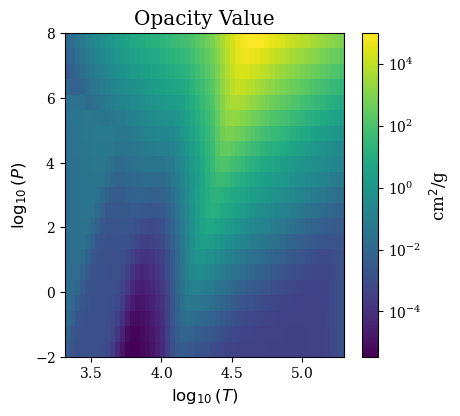

In [ ]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4.5, 4.2))
# Plot the 2D colormap with log normalization
cax = ax.imshow(K, cmap='viridis', aspect='auto', extent=[Tk.min(), Tk.max(), Pk.min(), Pk.max()], origin='lower', norm=LogNorm())

ax.set_xlabel(r'$\log_{10}(T)$')
ax.set_ylabel(r'$\log_{10}(P)$')
ax.set_title('Opacity Value')

fig.colorbar(cax, ax=ax, label=r'cm$^2$/g')
fig.savefig(images_output / "opacity_values.png")
plt.show()


Let's check that the temperature and pressure values we have in our dataset are inside the limits of our opacity temperature and pressure ranges.

In [ ]:
def limit_values(data, min_val, max_val):
        new_data = np.clip(data, min_val+0.00001, max_val-0.00001)
        return new_data
                
T_log = np.log10(muram_box[..., 0]) 
P_log = np.log10(mpre) 
T_log = limit_values(T_log, Tk.min(), Tk.max())
P_log = limit_values(P_log, Pk.min(), Pk.max())
PT_log = np.stack((P_log.flatten(), T_log.flatten()), axis=-1)

Define the interpolator for obtaining the corresponding opacity values to our simulation distribution of temperature and pressure.

In [ ]:
kappa_interp = RegularGridInterpolator((Pk,Tk), K, method="linear")

Now, let's apply the interpolation and create an array for the $\kappa\rho$ distribution.

In [ ]:
kappa_rho = np.zeros_like(muram_box[..., 0])
kappa_rho = kappa_interp(PT_log)
kappa_rho = kappa_rho.reshape(muram_box[...,0].shape)
kappa_rho = np.multiply(kappa_rho, muram_box[..., 1])

Finally, let's integrate for each pixel under the parallel-plane atmosphere assumption

In [ ]:
#Optical depth calculation
logtau_name = f"logtau_{filename}.npy"
if not os.path.exists(geom_path / logtau_name): #In case the optical depth has not been calculated yet
    tau = np.zeros_like(kappa_rho)
    dz = 1e6 # 10 km -> 1e6 cm
    tau[:,:,nz-1] = 1e-5

    print("Calculating optical depth...")
    for iz in tqdm(range(1,nz)):
        for ix in range(nx):
            for iy in range(ny):
                kpz = kappa_rho[ix,iy,nz-1-iz:]
                tau[ix,iy,nz-1-iz] = simpson(y = kpz, 
                                    dx = dz)
                
    muram_logtau = np.log10(tau)
    np.save(geom_path / logtau_name, muram_logtau)
    
else: #For visualization is better to load the optical depth values from the file for fast demonstration
    muram_logtau = np.load(geom_path / logtau_name)

Now that we have the logtau distribution of values, we will interpolate over each of the pixels to obtain the three nodes we are interested in.

In [ ]:
#New logtau nodes
new_logtau = np.array([-2.0,-0.8,0])
n_logtau = new_logtau.shape[0]

Let's define a function that maps the simulation values to our new nodes for a sole pixel

In [ ]:
def logtau_mapper(orig_arr: np.ndarray, 
    corresp_logtau: np.ndarray,
    new_logtau: np.ndarray,
    ) -> np.ndarray:
        """
        Function for mapping the quantities distribution from geometrical height to optical depth.
        Args:
            orig_arr(np.ndarray): Original array distributed along geometrical height to be mapped.
            corresp_logtau(np.ndarray): Distribution of optical depth for the original array.
            new_logtau(np.ndarray): Array of the new optical depth measurement of height for the mapping
        Returns:
            (np.ndarray) Array containing the mapped quantity to the new distribution on optical depth.
        """
        
        logtau_mapper = interp1d(x = corresp_logtau, y = orig_arr)
        new_arr = logtau_mapper(new_logtau)
        return new_arr

Now, for each quantity we must interpolate over each of the simulations surface pixels to obtain their values in each of the three nodes.

In [ ]:
opt_path = ptm / "opt_depth"
output_names = ["mtpr","mrho", "mvzz", "mbxx", "mbyy", "mbzz"]

In [ ]:
#Pixel by pixel iteration

#1. Atmospheric quantities iteration
atm_to_logtau = np.zeros((nx,ny,n_logtau,muram_box.shape[-1]))
for imur in range(muram_box.shape[-1]):
    out_map_name = f"{output_names[imur]}_logtau_{filename}_{n_logtau}_nodes.npy"
    
    # Check if the file exists
    if not os.path.exists(opt_path / out_map_name):
        #2. Pixel iteration
        geom_atm = muram_box[..., imur]
        new_muram_quantity = np.zeros((nx,ny,n_logtau))
        for ix in tqdm(range(nx)):
            for iy in range(ny):
                new_muram_quantity[ix,iy,:] = logtau_mapper(orig_arr = geom_atm[ix,iy,:], 
                                            corresp_logtau = muram_logtau[ix,iy,:], 
                                            new_logtau = new_logtau)
        atm_to_logtau[...,imur] = new_muram_quantity
        np.save(opt_path / out_map_name, new_muram_quantity)
        print(f"Saved to {opt_path / out_map_name}")
    else:
        # Load the file
        atm_to_logtau[...,imur] = np.load(opt_path / out_map_name)
        print(f"Loaded {output_names[imur]} from {opt_path / out_map_name}")
muram_box = atm_to_logtau

Loaded mtpr from /media/juanessao2000/hdd/PRINCIPAL-2023-2/PROYECTOS/PROYECTO_DL/data/opt_depth/mtpr_logtau_080000_3_nodes.npy
Loaded mrho from /media/juanessao2000/hdd/PRINCIPAL-2023-2/PROYECTOS/PROYECTO_DL/data/opt_depth/mrho_logtau_080000_3_nodes.npy
Loaded mvzz from /media/juanessao2000/hdd/PRINCIPAL-2023-2/PROYECTOS/PROYECTO_DL/data/opt_depth/mvzz_logtau_080000_3_nodes.npy
Loaded mbxx from /media/juanessao2000/hdd/PRINCIPAL-2023-2/PROYECTOS/PROYECTO_DL/data/opt_depth/mbxx_logtau_080000_3_nodes.npy
Loaded mbyy from /media/juanessao2000/hdd/PRINCIPAL-2023-2/PROYECTOS/PROYECTO_DL/data/opt_depth/mbyy_logtau_080000_3_nodes.npy
Loaded mbzz from /media/juanessao2000/hdd/PRINCIPAL-2023-2/PROYECTOS/PROYECTO_DL/data/opt_depth/mbzz_logtau_080000_3_nodes.npy


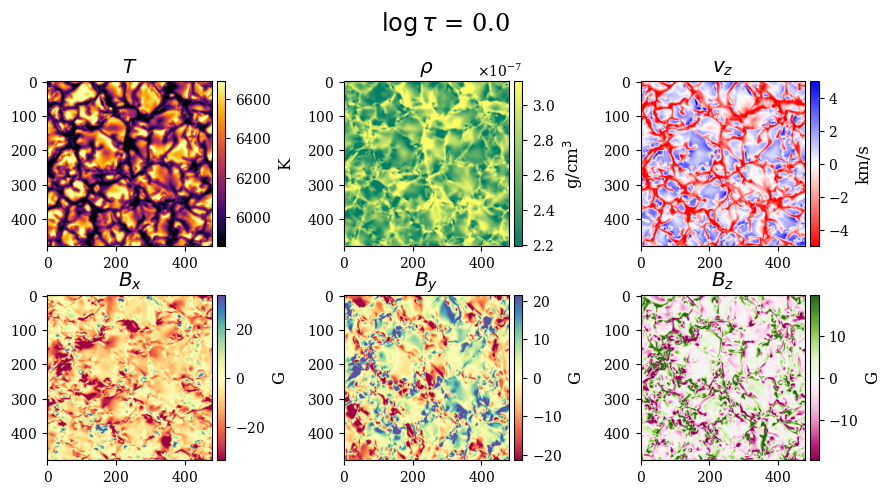

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

height_pix = -1
fig, ax = plt.subplots(2, 3, figsize=(3*3, 2*2.5))
fig.suptitle(r"$\log \tau$" + f" = {new_logtau[height_pix]}")
for i, (param_idx, title, unit, cmap) in enumerate(quantities):
  data = muram_box[...,height_pix,param_idx]
  if title in [r"$v_z$"]:  # Convert from cm/s to km/s
    data /= 1e5
  if title in [r"$v_z$", r"$B_x$", r"$B_y$",r"$B_z$"]:  # Magnetic field components and velocity need symmetric colorbars
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = -orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else orig_q5
    vmax = orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else -orig_q5
  else:
    # Calculate quantiles for colorbar limits based on original data
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = orig_q5
    vmax = orig_q95
  im = ax[i // 3, i % 3].imshow(data, cmap = cmap, vmin = vmin, vmax = vmax)
  ax[i // 3, i % 3].set_title(title)
  divider = make_axes_locatable(ax[i // 3, i % 3])
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(im, cax=cax, label=unit)
plt.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "muram_box_fixed_opt_depth.png", dpi=300)

plt.show()

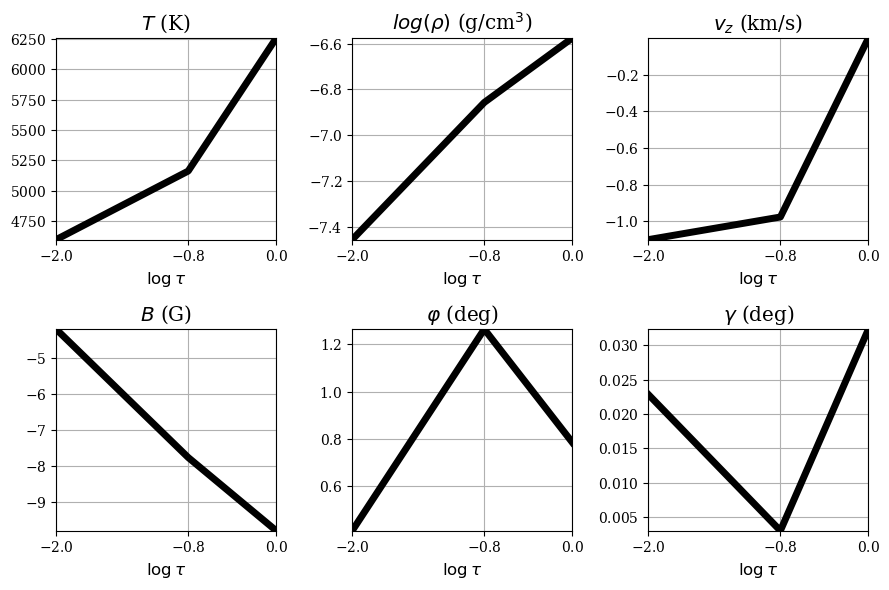

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(3*3, 2*3))

quantities = [
    (0, r"$T$", "K", "inferno"),
    (1, r"$log(\rho)$", r"g/cm$^3$", "spring"),
    (2, r"$v_z$", "km/s", "bwr_r"),
    (3, r"$B$", "G", "bwr_r"),
    (4, r"$\varphi$", "deg", "bwr_r"),
    (5, r"$\gamma$", "deg", "bwr_r")
]

for i, (param_idx, title, unit, cmap) in enumerate(quantities):
    data = muram_box[..., param_idx].mean(axis=(0, 1))
    iax = ax[i // 3, i % 3]
    if title == r"$log(\rho)$":
        data = np.log10(data)
        iax.plot(new_logtau, data, "k", linewidth=5)
    elif title == r"$v_z$":
        data = data / 1e5
        iax.plot(new_logtau, data, "k", linewidth=5)
    else:
        iax.plot(new_logtau, data, "k", linewidth=5)
    iax.set_xlabel(r"$\log \tau$")
    iax.set_title(f"{title} ({unit})")
    iax.set_xlim(new_logtau.min(), new_logtau.max())
    iax.grid(True)
    iax.set_ylim(data.min(), data.max())
    iax.set_xticks(new_logtau)

plt.tight_layout(w_pad=1.0, h_pad=1.0)
fig.savefig(images_output / "mean_profile_along_optical_depth.png", dpi=300)
plt.show()

Visualize the converted quantities!

### 2.3 Magnetic field strength, azimuth and zenith

Knowing that we have the magnetic field components $B_x$, $B_y$ and $B_z$, for calculating the magnetic field vector characteristics in spherical coordinates $(B,\varphi,\gamma)$ we have
\begin{align*}
    B &= \sqrt{B_x^2 + B_y^2 + B_z^2}\;;\\
    \varphi &= \arctan{\left(\frac{B_y}{Bx}\right)}\;;\\
    \gamma &= \arctan{\left(\frac{Bz}{\sqrt{B_x^2 + B_y^2}}\right)}\;.
\end{align*}

Additionally, for avoiding the azimuth ambiguity while we do the inversions, we restrict the values of the azimuth to $0 \le \varphi < 180$. Then, if values over 180 are obtained, we map them to the opposite angle by calculating
\begin{equation}
    \varphi' = (\varphi + 180) \% (2\pi)
\end{equation}

In [ ]:
# Opposite angle function
def opposite_angle(angle: float) -> float:
    """
    Calculate the opposite angle to avoid azimuth ambiguity.

    Parameters:
    angle (float): The original angle in degrees.

    Returns:
    float: The opposite angle in degrees.
    """
    opposite = (angle + np.pi) % (2 * np.pi)
    return opposite

In [ ]:
magnetic_field_strength = np.sqrt(muram_box[...,3]**2 + muram_box[...,4]**2 + muram_box[...,5]**2)
azimuth = np.arctan(muram_box[...,4]/muram_box[...,3])
azimuth = np.where(azimuth > np.pi, opposite_angle(azimuth), azimuth) # azimuth ambiguity
azimuth = np.where(azimuth < 0, opposite_angle(azimuth), azimuth) # azimuth ambiguity
azimuth = np.rad2deg(azimuth)
zenith = np.rad2deg(np.arctan(muram_box[...,5]/np.sqrt(muram_box[...,3]**2 + muram_box[...,4]**2)))

In [ ]:
muram_box[...,3] = magnetic_field_strength
muram_box[...,4] = azimuth
muram_box[...,5] = zenith

Let's plot them to check their vertical and surface distribution.

In [ ]:
modified_quantities = [
    (0, r"$T$", "K", "inferno"),
    (1, r"$\rho$", r"g/cm$^3$", "spring"),
    (2, r"$v_z$", "km/s", "bwr_r"),
    (3, r"$B$", "G", "bwr_r"),
    (4, r"$\varphi$", "deg", "bwr_r"),
    (5, r"$\gamma$", "deg", "bwr_r")
]


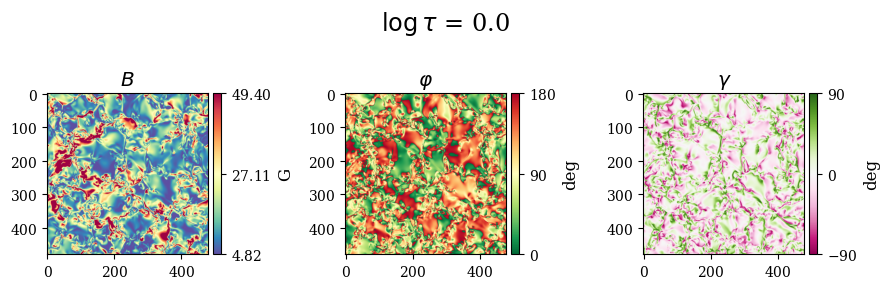

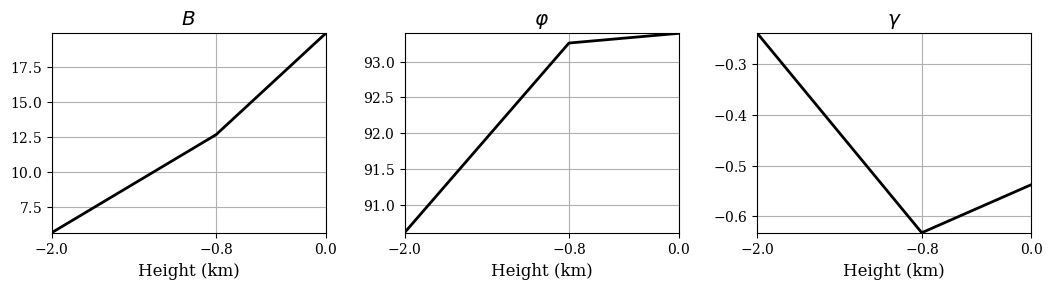

In [ ]:
# Plot the modified components of the magnetic field using imshow for the surface at a fixed height
height_pix = -1
fig, ax = plt.subplots(1, 3, figsize=(3*3, 3))
fig.suptitle(r"$\log \tau$" + f" = {new_logtau[height_pix]}")
modified_titles = [r"$B$", r"$\varphi$", r"$\gamma$"]
colormaps = ["Spectral_r", "RdYlGn_r", "PiYG"]
v_minmax = [(0, 1000), (0, 180), (-90, 90)]

for i, param_idx in enumerate([3, 4, 5]):
    data = muram_box[..., height_pix,param_idx]
    if modified_titles[i] in [r"$B$"]:
        orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
        vmin = orig_q5
        vmax = orig_q95
    else:
        vmin, vmax = v_minmax[i]
    im = ax[i].imshow(data, cmap=colormaps[i], vmin=vmin, vmax=vmax)
    ax[i].set_title(modified_quantities[param_idx][1])
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, label=modified_quantities[param_idx][2])
    cbar.set_ticks([vmin, (vmin + vmax) / 2, vmax])

plt.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "modified_magnetic_field_fixed_height.png", dpi=300)
plt.show()

# Plot the mean value along height for the modified components of the magnetic field
fig, ax = plt.subplots(1, 3, figsize=(3*3.5, 3))
for i, param_idx in enumerate([3, 4, 5]):
    data = muram_box[..., param_idx].mean(axis=(0, 1))
    ax[i].plot(new_logtau, data, "k")
    ax[i].set_xlabel("Height (km)")
    ax[i].set_title(modified_titles[i])
    ax[i].set_xlim(new_logtau.min(), new_logtau.max())
    ax[i].grid(True)
    ax[i].set_ylim(data.min(), data.max())
    ax[i].set_xticks(new_logtau)

plt.tight_layout(w_pad=1.0, h_pad=1.0)
fig.savefig(images_output / "modified_magnetic_field_mean_profile.png", dpi=300)
plt.show()

### 2.4 Charge the Stokes parameters

Having the atmosphere magnitudes charged, we need to charge now the radiation information contained in the Stokes parameters generated for our simulation.

In [6]:
print("Charging Stokes vectors...")
stokes = np.load(ptm / "stokes" / f"{filename}_prof.npy")
print("Charged!")
print("stokes shape", stokes.shape)

Charging Stokes vectors...
Charged!
stokes shape (480, 480, 300, 4)


Let's plot the surface image and the wavelength spectra for a random surface pixel.

In [7]:
import random

test_x = random.randint(0, 480)
test_y = random.randint(0, 480)

print(f"test_x: {test_x}, test_y: {test_y}")

test_x: 40, test_y: 455


<>:38: SyntaxWarning: invalid escape sequence '\A'
<>:38: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_8431/3672729136.py:38: SyntaxWarning: invalid escape sequence '\A'
  print(r"$\Delta \lambda$" + f"= {wl[1] - wl[0]:.3f} $\AA$")


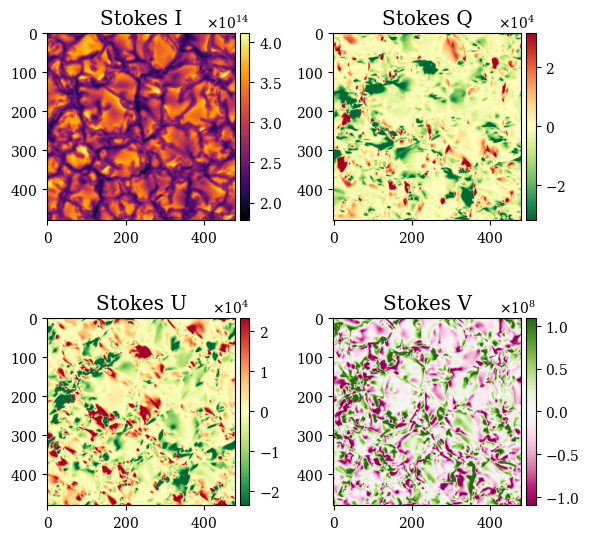

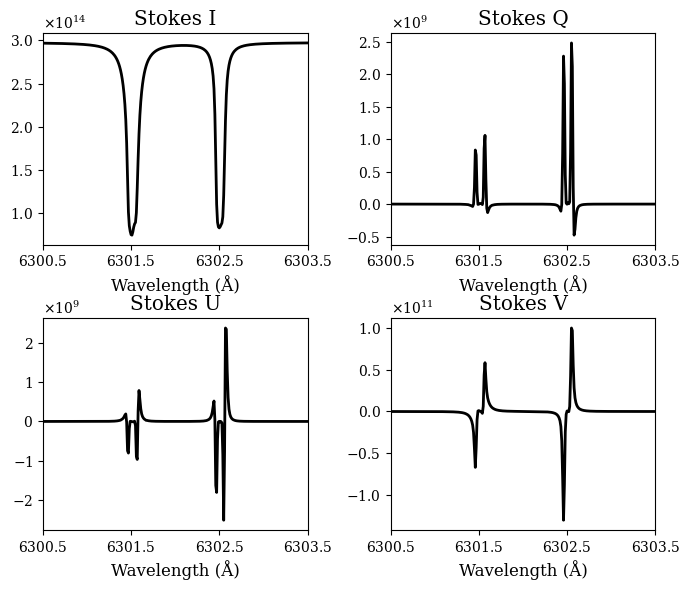

$\Delta \lambda$= 0.010 $\AA$


In [8]:
wl_pix = 0 #pixel in the continuum

colormaps = ["inferno", "RdYlGn_r", "RdYlGn_r", "PiYG"]
# Surface plot
fig, ax = plt.subplots(2, 2, figsize=(2*3, 2*3))
stokes_titles = ["Stokes I", "Stokes Q", "Stokes U", "Stokes V"] 
for i in range(len(stokes_titles)):
    data = stokes[..., wl_pix, i]
    if i > 0:  # Apply restriction for Q, U, V
        q5, q95 = np.percentile(data, [5, 95])
        vmin = -max(abs(q5), abs(q95))
        vmax = max(abs(q5), abs(q95))
    else:
        vmin, vmax = None, None
    im = ax[i // 2, i % 2].imshow(data, cmap=colormaps[i], vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(ax[i // 2, i % 2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    ax[i // 2, i % 2].set_title(stokes_titles[i])
fig.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "stokes_surface_plot.png", dpi=300)
plt.show()

# Spectral plot
fig, ax = plt.subplots(2, 2, figsize=(2*3.5, 2*3))
wl = (np.arange(300) + 6300) * 0.01
stokes_titles = ["Stokes I", "Stokes Q", "Stokes U", "Stokes V"] 
wl = np.arange(6300.5, 6303.5, 0.01)
for i in range(len(stokes_titles)):
    ax[i // 2, i % 2].plot(wl, stokes[test_x, test_y,:,i], "k")
    ax[i // 2, i % 2].set_title(stokes_titles[i])
    ax[i // 2, i % 2].set_xlabel("Wavelength (Å)")
    ax[i // 2, i % 2].set_xlim(wl.min(), wl.max())
    ax[i // 2, i % 2].set_xticks([6300.5, 6301.5, 6302.5, 6303.5])
fig.tight_layout(w_pad=1.0, h_pad=0.01)
fig.savefig(images_output / "stokes_spectral_plot.png", dpi=300)
plt.show()
print(r"$\Delta \lambda$" + f"= {wl[1] - wl[0]:.3f} $\AA$")

### 2.5 Degrading spectral resolution

The spectral resolution on satellites doing spectropolarimetric measurements on the sun has, as best, 112 points of spectral resolution. This means that it is necessary to degrade the 300 spectral points we have. For this, we are going to apply convolution with a gaussian LSF.

In [ ]:
old_stokes = stokes.copy()
#Number of spectral points
new_points = 112
# New spectral resolution arrays
new_resol = np.linspace(0,288,new_points, dtype=np.int64)
new_resol = np.add(new_resol, 6)
#File to save the degraded stokes
resampled_dir = ptm / "resampled_stokes"
new_stokes_out = resampled_dir / f"resampled_stokes_f{filename}_sr{new_points}_wl_points.npy"

#Degradation process
if not os.path.exists(new_stokes_out):

    # Gaussian LSF kernel definition
    N_kernel_points = 13 # number of points of the kernel.
    def gauss(n=N_kernel_points,sigma=1):
        r = range(-int(n/2),int(n/2)+1)
        return np.array([1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-float(x)**2/(2*sigma**2)) for x in r])
    g = gauss()    

    #Convolution
    print("Degrading...")
    new_stokes = np.zeros((nx, ny, new_points, stokes.shape[-1]))
    
    for s in range(stokes.shape[-1]):
        for jx in tqdm(range(nx)):
            for jy in range(ny):
                spectrum = stokes[jx, jy,:,s]
                resampled_spectrum = np.zeros(new_points)
                i = 0
                for center_wl in new_resol:
                    low_limit = center_wl-6
                    upper_limit = center_wl+7

                    if center_wl == 6:
                        shorten_spect = spectrum[0:13]
                    elif center_wl == 294:
                        shorten_spect = spectrum[-14:-1]
                    else:
                        shorten_spect = spectrum[low_limit:upper_limit]

                    resampled_spectrum[i] = np.sum(np.multiply(shorten_spect,g))
                    i += 1
                new_stokes[jx, jy,:,s] = resampled_spectrum
                new_stokes[jx,jy,:, s] += 1e-4 * np.random.randn(new_points) * np.max(new_stokes[jx,jy,:, 0], axis=0)
    np.save(new_stokes_out, new_stokes)
else:
    new_stokes = np.load(new_stokes_out)
    print("stokes degraded!")
stokes = new_stokes
del new_stokes

Degrading...


100%|██████████| 480/480 [01:05<00:00,  7.30it/s]


In [11]:
new_wl = (new_resol*0.01)+6300.5
new_wl.shape

(112,)

Let's plot the results

<>:36: SyntaxWarning: invalid escape sequence '\A'
<>:36: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_8431/1005427637.py:36: SyntaxWarning: invalid escape sequence '\A'
  print(r"$\Delta \lambda$" + f"= {new_wl[1] - new_wl[0]:.3f} $\AA$")


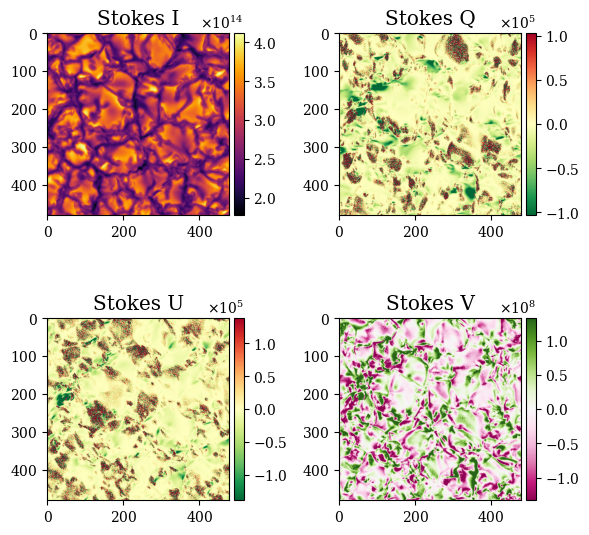

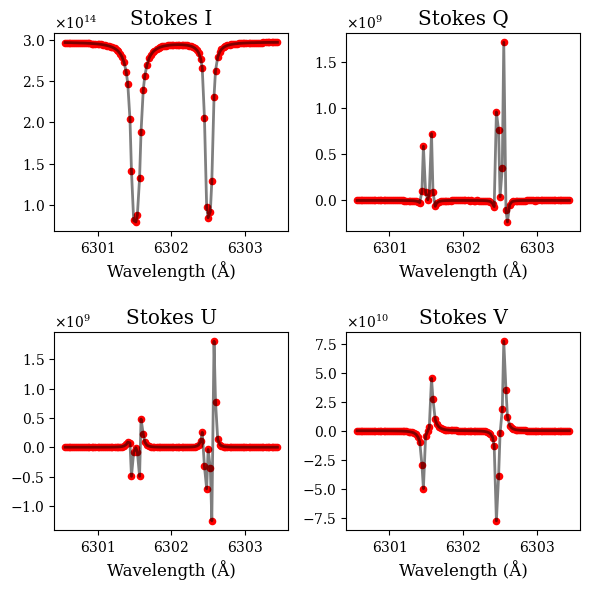

$\Delta \lambda$= 0.020 $\AA$


In [13]:
new_wl = (new_resol*0.01)+6300.5
wl_pix = 0 #pixel in the continuum

# Surface plot
fig, ax = plt.subplots(2, 2, figsize=(2*3, 2*3))
stokes_titles = ["Stokes I", "Stokes Q", "Stokes U", "Stokes V"]
colormaps = ["inferno", "RdYlGn_r", "RdYlGn_r", "PiYG"]

for i in range(len(stokes_titles)):
    data = stokes[:, :, wl_pix, i]
    if i > 0:  # Apply restriction for Q, U, V
        q5, q95 = np.percentile(data, [5, 95])
        vmin = -max(abs(q5), abs(q95))
        vmax = max(abs(q5), abs(q95))
    else:
        vmin, vmax = None, None
    im = ax[i // 2, i % 2].imshow(data, cmap=colormaps[i], vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(ax[i // 2, i % 2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    ax[i // 2, i % 2].set_title(stokes_titles[i])
fig.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "stokes_surface_plot_resampled.png", dpi=300)
plt.show()

# Spectral plot
fig, ax = plt.subplots(2, 2, figsize=(2*3, 2*3))
for i in range(len(stokes_titles)):
    ax[i // 2, i % 2].plot(new_wl, stokes[test_x, test_y, :, i], "k", linewidth = 2, alpha = 0.5)
    ax[i // 2, i % 2].scatter(new_wl, stokes[test_x, test_y, :, i], s = 20, color = "red")
    ax[i // 2, i % 2].set_title(stokes_titles[i])
    ax[i // 2, i % 2].set_xlabel("Wavelength (Å)")
fig.tight_layout(w_pad=1.0, h_pad=2)
fig.savefig(images_output / "stokes_spectral_plot_resampled.png", dpi=300)
plt.show()
print(r"$\Delta \lambda$" + f"= {new_wl[1] - new_wl[0]:.3f} $\AA$")

### 2.5 Scale the data

For the data to be treated by the neural network models, it is necessary to scale it. First, let's check the values of the magnitudes so that we are sure they were correctly scaled.

In [22]:
print(f""" STOKES:
I_max = {np.max(stokes[:,:,:,0])}
Q_max = {np.max(stokes[:,:,:,1])}
U_max = {np.max(stokes[:,:,:,2])}
V_max = {np.max(stokes[:,:,:,3])}
I_min = {np.min(stokes[:,:,:,0])}
Q_min = {np.min(stokes[:,:,:,1])}
U_min = {np.min(stokes[:,:,:,2])}
V_min = {np.min(stokes[:,:,:,3])}
""")

print(f"""
MAX VALUES:
mtpr max = {np.max(muram_box[...,:,:,0])}
mrho max = {np.max(muram_box[...,:,:,1])}
mbqq max = {np.max(muram_box[...,:,:,2])}
mbuu max = {np.max(muram_box[...,:,:,3])}
mbvv max = {np.max(muram_box[...,:,:,4])}
mvyy max = {np.max(muram_box[...,:,:,5])}
    """)

print(f"""
MIN VALUES:
mtpr min = {np.min(muram_box[...,:,:,0])}
mrho min = {np.min(muram_box[...,:,:,1])}
mbqq min = {np.min(muram_box[...,:,:,2])}
mbuu min = {np.min(muram_box[...,:,:,3])}
mbvv min = {np.min(muram_box[...,:,:,4])}
mvyy min = {np.min(muram_box[...,:,:,5])}
    """) 

 STOKES:
I_max = 412528257732613.25
Q_max = 103530211650.18213
U_max = 47077902528.8959
V_max = 2596521869792.119
I_min = 23441386696431.18
Q_min = -149906306880.5971
U_min = -143124518135.99756
V_min = -2839551448606.123



NameError: name 'muram_box' is not defined

Now, let's define the scaling factors. For the Stokes parameters we will normalize by the continuum of the intensity, while for the atmospheric magnitudes we will use scale factors determined in terms of the mean maximum and minimum values of each magnitude along all the steps of the simulation. This study is shown [in this other notebook](./Check_data.ipynb).

In [ ]:
#Atmosphere magnitudes scale factors
phys_maxmin = {}
phys_maxmin["T"] = [2e4, 0]
phys_maxmin["Rho"] = [1e-5, 1e-10]
phys_maxmin["V"] = [1e6, -1e6]
phys_maxmin["B"] = [3e3, -3e3]
phys_maxmin["Gamma"] = [180, 0] #restriction for avoiding azimuth ambiguity
phys_maxmin["Phi"] = [90, -90]

Let's define a minmax normalizing function.

In [14]:
def norm_func(arr, maxmin):
    max_val = maxmin[0]
    min_val = maxmin[1]
    return (arr-min_val)/(max_val-min_val)

For the normalization by the continuum it is necessary to establish a function that should describe the behaviour of the intensity without the absorption lines, and this is done by applying an spline interpolation function over the corresponding wavelength values that seem to not show absorption or emiting behaviours.

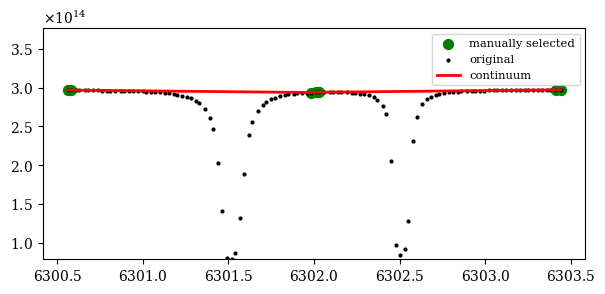

In [15]:
#Selection of the indices that we assume generally correspond to continuum in our data.
cont_indices = [0,1,int(len(new_wl)/2)-1,int(len(new_wl)/2),int(len(new_wl)/2)+1,-2,-1]


wl_cont_values = new_wl[cont_indices] #corresponding wavelength values to the selected continuum indices
cont_values = stokes[test_x, test_y,cont_indices,0] #corresponding intensity values to the selected continuum indices

cont_model = interp1d(wl_cont_values, cont_values, kind="linear") #Interpolation applied over the assumed continuum values

fig, ax = plt.subplots(figsize = (7,3))
ax.scatter(wl_cont_values, cont_values, label = "manually selected", color = "green", s = 50)
ax.scatter(new_wl, stokes[test_x, test_y, :, 0], label = "original", color = "black", s = 4)
ax.plot(new_wl, cont_model(new_wl), label="continuum", color = "red")
ymin = np.min(stokes[test_x, test_y,:,0])
ymax = np.max(stokes[test_x, test_y,:,0])
ax.set_ylim((ymin, ymax+ymin))
ax.legend()
fig.savefig(images_output / "continuum_interpolation.png", dpi=300)
plt.show()

Having both the scale factors and the algorithm for finding the continuum model in each pixel...let's normalize the data!

In [ ]:
#Atmosphere magnitudes normalization
muram_box[...,0] = norm_func(muram_box[...,0], phys_maxmin["T"])
muram_box[...,1] = norm_func(muram_box[...,1], phys_maxmin["Rho"])
muram_box[...,2] = norm_func(muram_box[...,5], phys_maxmin["V"])
muram_box[...,3] = norm_func(muram_box[...,2], phys_maxmin["B"])
muram_box[...,4] = norm_func(muram_box[...,3], phys_maxmin["varphi"])
muram_box[...,5] = norm_func(muram_box[...,4], phys_maxmin["gamma"])


In [16]:
#Stokes parameter normalization by the continuum
scaled_dir = ptm / "scaled_stokes"
if not os.path.exists(scaled_dir):
    os.makedirs(scaled_dir)
    
scaled_out = scaled_dir / f"scaled_stokes_{filename}_sr{new_points}_wl_points.npy"
print(scaled_out)
#if not os.path.exists(scaled_out):
scaled_stokes = np.ones_like(stokes)
scaled_old_stokes = np.ones_like(old_stokes)
mean_continuum = np.ones_like(stokes[...,0,0])
cont_indices = [0,1,int(len(wl)/2)-1,int(len(wl)/2),int(len(wl)/2)+1,-2,-1]
wl_cont_values = wl[cont_indices] #corresponding wavelength values to the selected continuum indices

for jx in tqdm(range(nx)):
    for jy in range(ny):
        for i in range(stokes.shape[-1]):
            cont_values = old_stokes[jx, jy,cont_indices,0] #corresponding intensity values to the selected continuum indices
            
            cont_model = interp1d(wl_cont_values, cont_values, kind="linear") #Interpolation applied over the assumed continuum values

            scaled_stokes[jx, jy,:,i] = stokes[jx, jy,:,i]/cont_model(new_wl)
            scaled_old_stokes[jx, jy,:,i] = old_stokes[jx, jy,:,i]/cont_model(wl)

            mean_continuum[jx,jy] = cont_model(new_wl).mean()
stokes = scaled_stokes
old_stokes = scaled_old_stokes
np.save(scaled_out, stokes)
#else: 
#    stokes = np.load(scaled_out)
#    print("stokes scaled!")

scaling_importance = [1, 7, 7, 4] #Stokes parameters importance levels -> mapping Q, U and V to 0.1 of the intensity scale
for i in range(len(scaling_importance)):
    stokes[:,:,:,i] = stokes[:,:,:,i]*scaling_importance[i] 
mean_continuum = norm_func(mean_continuum, [mean_continuum.max(), mean_continuum.min()])

../data/scaled_stokes/scaled_stokes_080000_sr112_wl_points.npy


100%|██████████| 480/480 [00:40<00:00, 11.96it/s]


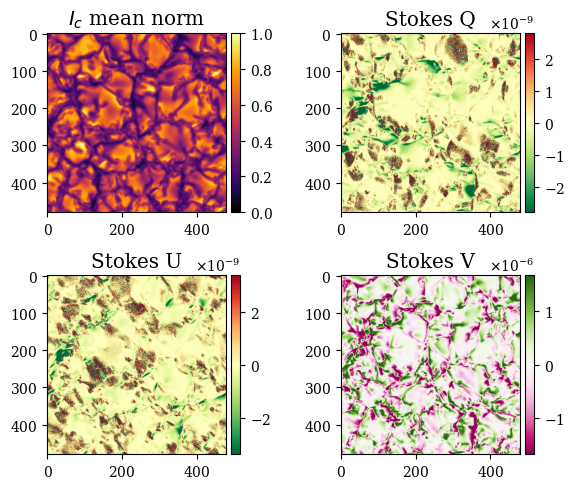

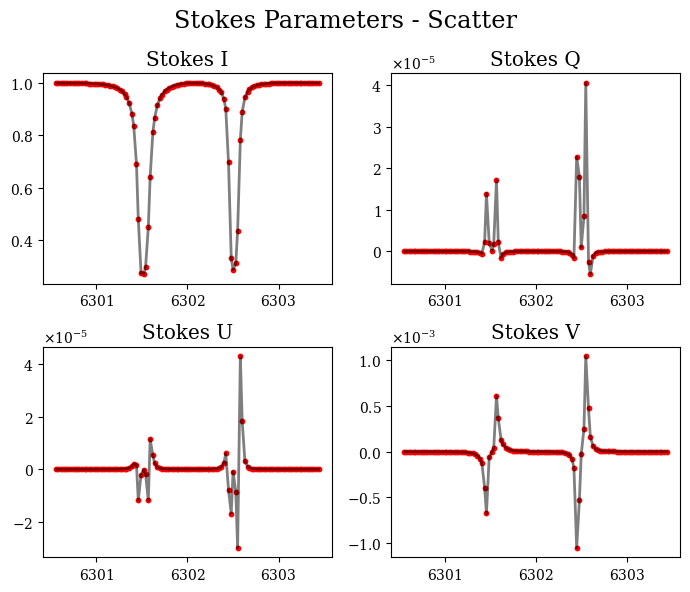

In [17]:
# First figure: imshow plots
fig1, ax1 = plt.subplots(2, 2, figsize=(3*2, 2.5*2))
# First plot: imshow of stokes parameters
for i in range(4):
    if i == 0:
        im = ax1[i // 2, i % 2].imshow(mean_continuum, cmap=colormaps[i])
        ax1[i // 2, i % 2].set_title("$I_c$ mean norm")
    else:
        q5, q95 = np.percentile(stokes[:, :, -1, i], [5, 95])
        vmin = -max(abs(q5), abs(q95))
        vmax = max(abs(q5), abs(q95))
        im = ax1[i // 2, i % 2].imshow(stokes[:, :, -1, i], cmap=colormaps[i], vmin=vmin, vmax=vmax)
        ax1[i // 2, i % 2].set_title(stokes_titles[i])
    divider = make_axes_locatable(ax1[i // 2, i % 2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig1.colorbar(im, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
    cbar.update_ticks()

fig1.tight_layout()
plt.show()

# Second figure: scatter plots
fig2, ax2 = plt.subplots(2, 2, figsize=(2*3.5, 2*3))
fig2.suptitle("Stokes Parameters - Scatter")

# Second plot: scatter of stokes parameters
for i in range(4):
    ax2[i // 2, i % 2].scatter(new_wl, stokes[test_x, test_y, :, i], color = "red", s = 10)
    ax2[i // 2, i % 2].plot(new_wl, stokes[test_x, test_y, :, i], color = "black", linewidth = 2, alpha =0.5)
    ax2[i // 2, i % 2].set_title(stokes_titles[i])

fig2.tight_layout()
plt.show()

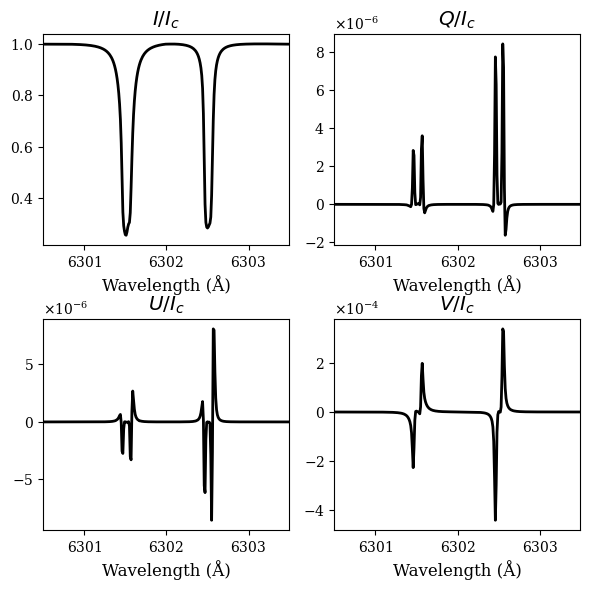

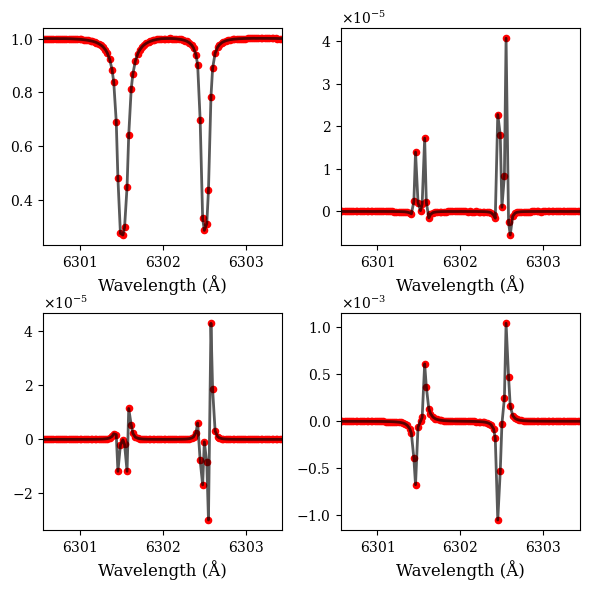

In [18]:
# Plot the old stokes
fig, ax = plt.subplots(2, 2, figsize=(2*3, 2*3))
stokes_titles = [r"$I/I_c$", r"$Q/I_c$", r"$U/I_c$", r"$V/I_c$"]

for i in range(len(stokes_titles)):
    ax[i // 2, i % 2].plot(wl, old_stokes[test_x, test_y, :, i], "k")
    ax[i // 2, i % 2].set_title(stokes_titles[i])
    ax[i // 2, i % 2].set_xlabel("Wavelength (Å)")
    ax[i // 2, i % 2].set_xlim(wl.min(), wl.max())
fig.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "old_stokes_profile.png", dpi=300)
plt.show()

# Plot the new stokes normalized
fig, ax = plt.subplots(2, 2, figsize=(2*3, 2*3))
for i in range(len(stokes_titles)):
    ax[i // 2, i % 2].plot(new_wl, stokes[test_x, test_y, :, i], "k", linewidth = 2, alpha = 0.65)
    ax[i // 2, i % 2].scatter(new_wl, stokes[test_x, test_y, :, i], s=20, color="red")
    ax[i // 2, i % 2].set_xlabel("Wavelength (Å)")
    ax[i // 2, i % 2].set_xlim(new_wl.min(), new_wl.max())
fig.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "new_stokes_profile.png", dpi=300)
plt.show()
del old_stokes



Let's check the new maximum and minimum values.

In [ ]:
print(f""" STOKES:
I_max = {np.max(stokes[:,:,:,0])}
Q_max = {np.max(stokes[:,:,:,1])}
U_max = {np.max(stokes[:,:,:,2])}
V_max = {np.max(stokes[:,:,:,3])}
I_min = {np.min(stokes[:,:,:,0])}
Q_min = {np.min(stokes[:,:,:,1])}
U_min = {np.min(stokes[:,:,:,2])}
V_min = {np.min(stokes[:,:,:,3])}
""")

print(f"""
MAX VALUES:
mtpr max = {np.max(muram_box[...,:,:,0])}
mrho max = {np.max(muram_box[...,:,:,1])}
mbqq max = {np.max(muram_box[...,:,:,2])}
mbuu max = {np.max(muram_box[...,:,:,3])}
mbvv max = {np.max(muram_box[...,:,:,4])}
mvyy max = {np.max(muram_box[...,:,:,5])}
    """)

print(f"""
MIN VALUES:
mtpr min = {np.min(muram_box[...,:,:,0])}
mrho min = {np.min(muram_box[...,:,:,1])}
mbqq min = {np.min(muram_box[...,:,:,2])}
mbuu min = {np.min(muram_box[...,:,:,3])}
mbvv min = {np.min(muram_box[...,:,:,4])}
mvyy min = {np.min(muram_box[...,:,:,5])}
    """) 

 STOKES:
I_max = 1.0138675819294234
Q_max = 7.0
U_max = 7.0
V_max = 4.0
I_min = 0.07401000106186151
Q_min = -0.004392367962689186
U_min = -0.0030023906760316033
V_min = -0.03165851778983939


MAX VALUES:
mtpr max = 0.3508320936623423
mrho max = 0.04011245586700807
mbqq max = 93.90300627604991
mbuu max = 0.5454041259285709
mbvv max = 0.5299999775284923
mvyy max = 0.500044910301212
    

MIN VALUES:
mtpr min = 0.1764396416426181
mrho min = 0.002162054407399103
mbqq min = -132.13817312057216
mbuu min = 0.5000100780151254
mbvv min = 0.500000039851062
mvyy min = 0.49995510848284913
    


In [ ]:
muram_box.shape, stokes.shape

((480, 480, 3, 6), (480, 480, 112, 4))

### 2.6 Filtering the data by granular and intergranular zones

Granular and intergranular regions has different physicial behaviou, meaning that if we want to assess correctly the information on the calm sun we must balance the data we have over this two regions, meaning that we need to have the same amount on data on both. For this, we will apply a threshold used in computer vision for separating _foreground_ from _background_ over the intensity outside of the absorption lines. This parameter was selected in previous sections as the first value of the spectra over each pixel.

Text(0.5, 1.0, 'Intensity in the continuum')

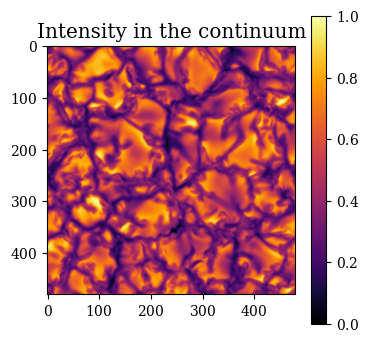

In [20]:
fig, ax = plt.subplots(figsize = (4,4))
im = ax.imshow(mean_continuum, cmap = "inferno")
fig.colorbar(im, ax = ax)
ax.set_title("Intensity in the continuum")

Having the intensity in the continuum, let's apply the Otsu's threshold and check how the separation looks like

In [21]:
#Threshold definition
thresh1 = filters.threshold_otsu(mean_continuum)

#Mask extraction
im_bin = mean_continuum<thresh1
gran_mask =  np.ma.masked_array(mean_continuum, mask=im_bin).mask
inter_mask = np.ma.masked_array(mean_continuum, mask=~im_bin).mask

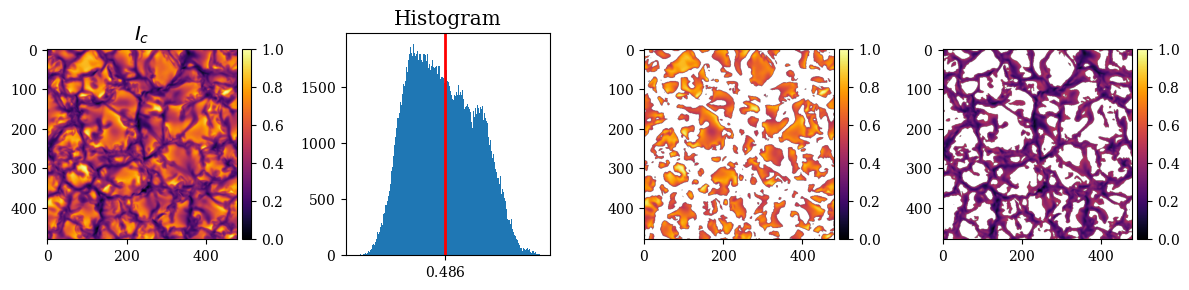

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(3*4, 3))

cmap = "inferno"
im = ax[0].imshow(mean_continuum, cmap=cmap)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)
vmin, vmax = [np.min(mean_continuum), np.max(mean_continuum)]
ax[0].set_title(r"$I_{c}$")

ax[1].hist(mean_continuum.ravel(), bins=256)
ax[1].set_xticks([thresh1])
ax[1].set_title('Histogram')
ax[1].axvline(thresh1, color='r')

im2 = ax[2].imshow(np.ma.masked_array(mean_continuum, mask=im_bin), vmin=vmin, vmax=vmax, cmap=cmap)
divider2 = make_axes_locatable(ax[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)

im3 = ax[3].imshow(np.ma.masked_array(mean_continuum, mask=~im_bin), vmin=vmin, vmax=vmax, cmap=cmap)
divider3 = make_axes_locatable(ax[3])
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im3, cax=cax3)

fig.tight_layout()
fig.savefig(images_output / "Otsu_thres_I_stokes.png", transparent=False)
plt.show()

### 2.7 Masking through Polarimetric information

In [ ]:
linear_polarimetry = 

Having the threshold applied, let's save the atmosphere quantities corresponding to each region.

In [23]:
#Mask application
muram_box_gran = muram_box[gran_mask]
muram_box_inter = muram_box[inter_mask]
stokes_gran = stokes[gran_mask]
stokes_inter = stokes[inter_mask]
len_inter = muram_box_inter.shape[0]
len_gran = muram_box_gran.shape[0]

NameError: name 'muram_box' is not defined

In [ ]:
muram_box_gran.shape, muram_box_inter.shape, stokes_gran.shape, stokes_inter.shape

((126582, 3, 6), (103818, 3, 6), (126582, 112, 4), (103818, 112, 4))

Having the regions pixels selected, let's balance the amount of data on both of them.

In [ ]:
#leveraging the quantity of data from the granular and intergranular zones by a random dropping of elements of the greater zone.
print("leveraging...")
index_select  = []
np.random.seed(50)
if len_inter < len_gran:
    index_select = np.random.choice(range(len_gran), size = (len_inter,), replace = False)
    muram_box_leveraged = np.concatenate((muram_box_gran[index_select], muram_box_inter), axis = 0)
    stokes_leveraged = np.concatenate((stokes_gran[index_select], stokes_inter), axis = 0)
elif len_inter > len_gran:
    index_select = np.random.choice(range(len_inter), size = (len_gran,), replace = False)
    muram_box_leveraged = np.concatenate((muram_box_gran, muram_box_inter[index_select]), axis = 0)
    stokes_leveraged = np.concatenate((stokes_gran, stokes_inter[index_select]), axis = 0)
print("Done")

leveraging...
Done


In [ ]:
muram_box_leveraged.shape, stokes_leveraged.shape

((207636, 3, 6), (207636, 112, 4))